In [1]:
import sys
import os
sys.path.append('..')


# Prepare model

In [2]:
import torch
from comic_ocr.models import localization
from comic_ocr.utils import get_path_project_dir
from comic_ocr.utils.pytorch_model import get_total_parameters_count
from comic_ocr.models.localization.conv_unet.conv_unet import BaselineConvUnet

model_name = 'localization_base'
model_path = get_path_project_dir(f'data/output/models/{model_name}.bin')


model = BaselineConvUnet()
# model = localization.load_model(model_path)

In [3]:
print('- preferred_image_size:', model.preferred_image_size)
print('- get_total_parameters_count', get_total_parameters_count(model))

dataset_example_path = get_path_project_dir('example/manga_annotated')
dataset_example = localization.LocalizationDataset.load_line_annotated_manga_dataset(
    dataset_example_path, batch_image_size=model.preferred_image_size)

localization.calculate_high_level_metrics(model, dataset_example)

- preferred_image_size: (500, 500)
- get_total_parameters_count 197986


{'sample_size': 4,
 'total_line_level_true_positive': 0,
 'total_line_level_false_positive': 100,
 'total_line_level_false_negative': 67,
 'line_level_precision': 0.0,
 'line_level_recall': 0.0,
 'line_level_accuracy': 0.0}

# Prepare Datasets

In [4]:
from comic_ocr.models.localization.localization_dataset import LocalizationDataset
from comic_ocr.utils.ploting import show_images

dataset_example 5


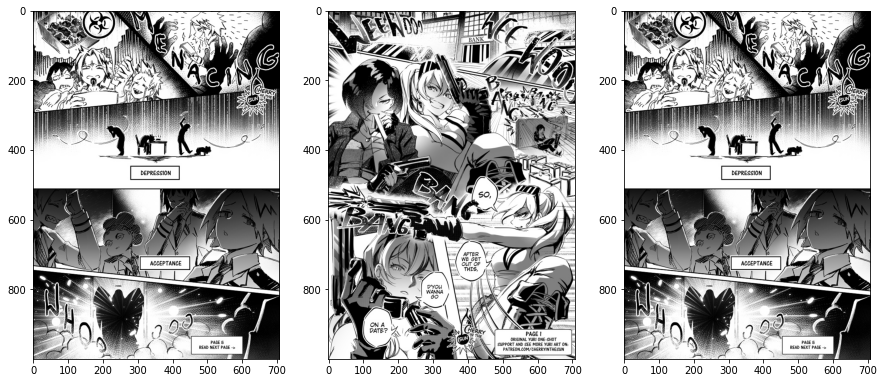

In [5]:
dataset_example_path = get_path_project_dir('example/manga_annotated')
dataset_example = LocalizationDataset.load_line_annotated_manga_dataset(
    dataset_example_path, batch_image_size=model.preferred_image_size)

print('dataset_example', len(dataset_example))


show_images([
    dataset_example.get_image(0), 
    dataset_example.get_image(1), 
    dataset_example.get_image(-5)
])

dataset_generated 350


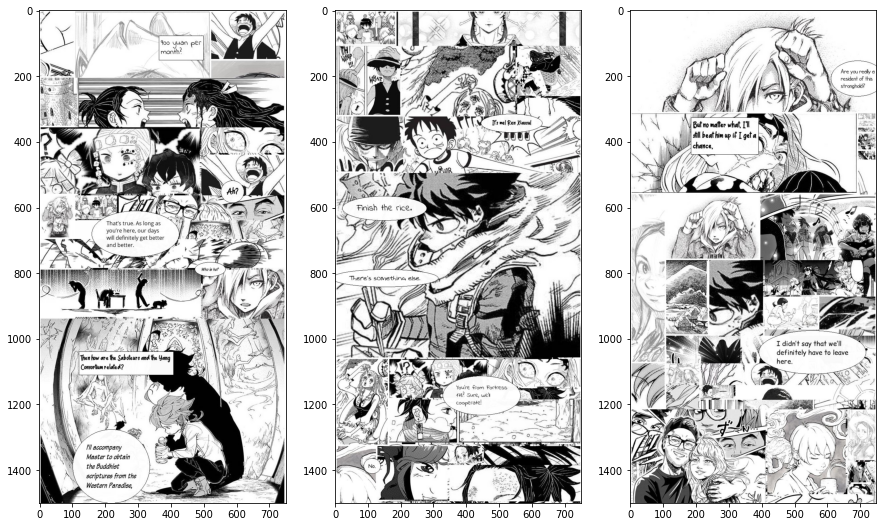

In [6]:
dataset_generated_path = get_path_project_dir('data/output/generate_manga_dataset')
dataset_generated = LocalizationDataset.load_generated_manga_dataset(
    dataset_generated_path, batch_image_size=model.preferred_image_size)

print('dataset_generated', len(dataset_generated))
show_images([
    dataset_generated.get_image(0), 
    dataset_generated.get_image(1), 
    dataset_generated.get_image(-1)
])

dataset_annotated 22
dataset_annotated_no_text 17


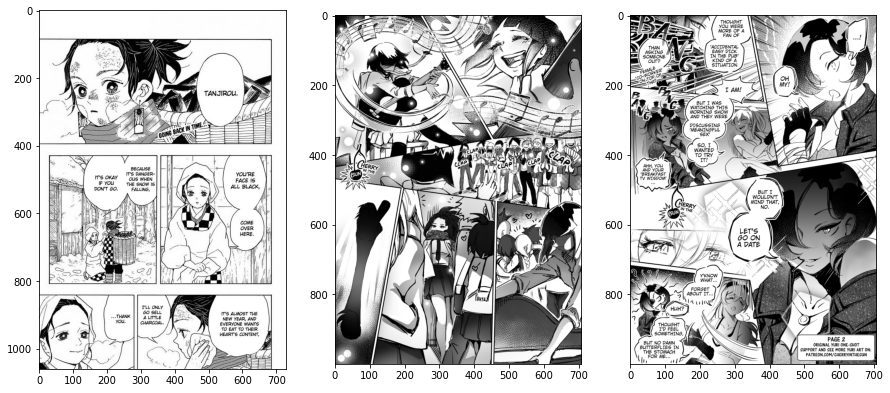

In [7]:
dataset_annotated_path = get_path_project_dir('data/manga_line_annotated')
dataset_annotated = LocalizationDataset.load_line_annotated_manga_dataset(
    dataset_annotated_path, batch_image_size=model.preferred_image_size)
print('dataset_annotated', len(dataset_annotated))

dataset_annotated_no_text_path = get_path_project_dir('data/manga_line_annotated_no_text')
dataset_annotated_no_text = LocalizationDataset.load_line_annotated_manga_dataset(
    dataset_annotated_no_text_path, batch_image_size=model.preferred_image_size)
print('dataset_annotated_no_text', len(dataset_annotated_no_text))

dataset_annotated = LocalizationDataset.merge(dataset_annotated, dataset_annotated_no_text).shuffle()
show_images([
    dataset_annotated.get_image(0), 
    dataset_annotated.get_image(1), 
    dataset_annotated.get_image(2)
])

## Train/Validation Datasets

Note: We include the `dataset_example` in both training and validation to make the model does well enough to pass unittests. This is not theoritically correct way to train the model.

In [8]:
import random
random.seed('abdc')
dataset_annotated = dataset_annotated.shuffle()
dataset_generated = dataset_generated.shuffle()
dataset_example = dataset_example.shuffle()

# Validation Dataset (annotated + example)
validation_dataset = LocalizationDataset.merge(
    dataset_example,
    dataset_annotated.subset(to_idx=10)
).shuffle()

# Training Dataset (generated + annotated + example)
training_dataset = LocalizationDataset.merge(
    dataset_annotated.subset(from_idx=10),
    dataset_generated.subset(from_idx=0),
).shuffle()

training_dataset = LocalizationDataset.merge(
    training_dataset,
    dataset_example,
).shuffle()

print('validation_dataset', len(validation_dataset))
print('training_dataset', len(training_dataset))

validation_dataset 15
training_dataset 384


# Training

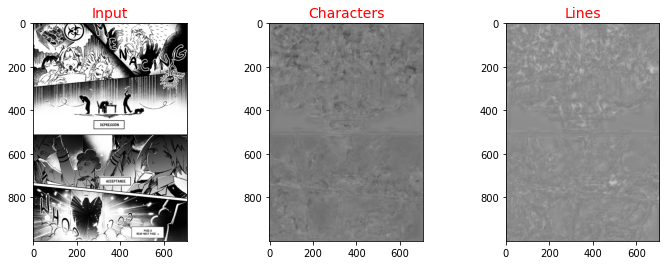

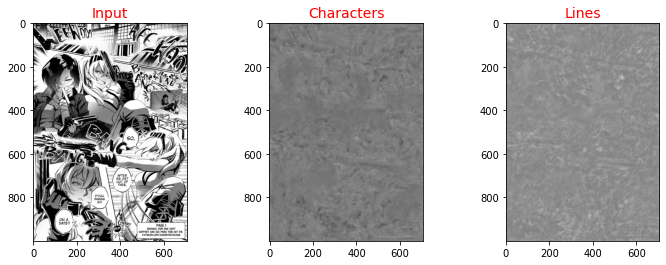

In [9]:
from comic_ocr.utils.ploting import plot_losses, plot_metrics, show_images
from IPython.display import clear_output
from comic_ocr.utils.files import load_image

example_1 = load_image(get_path_project_dir('example/manga_annotated/normal_01.jpg'))
example_2 = load_image(get_path_project_dir('example/manga_annotated/normal_02.jpg'))


def show_example(model, img):
    mask_char, mask_line = model.create_output_marks(img)
    show_images(
        images=[img, mask_char, mask_line], 
        texts=['Input', 'Characters', 'Lines'], 
        figsize=(12, 4), num_col=3
    )

show_example(model, example_1)
show_example(model, example_2)

In [10]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')


In [11]:
from comic_ocr.models.localization import train

# Saving the model on increasing precision
save_model = train.save_on_increasing_validate_metric(
    model, model_path, 'line_level_precision')

def save_and_report(step, train_metrics, validate_metrics):
    save_model(step, train_metrics, validate_metrics)
    clear_output()
    plot_metrics(metrics=[
        ('Training Losses', train_metrics['loss']),
        ('Validation Losses', validate_metrics['loss']),
        ('Line-level Precision', validate_metrics['line_level_precision']),
        ('Line-level Recall', validate_metrics['line_level_recall']),
    ], num_col=2, figsize=(10, 5))
    show_example(model, example_1)
    show_example(model, example_2)

<Figure size 720x360 with 0 Axes>

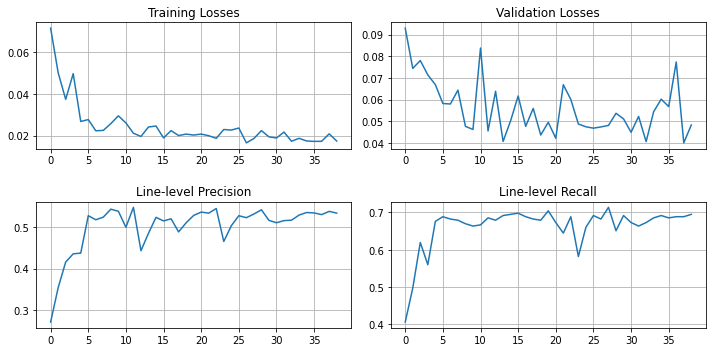

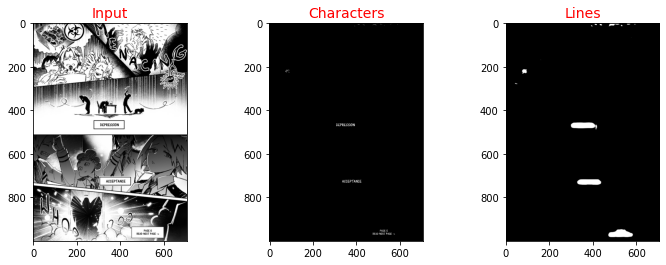

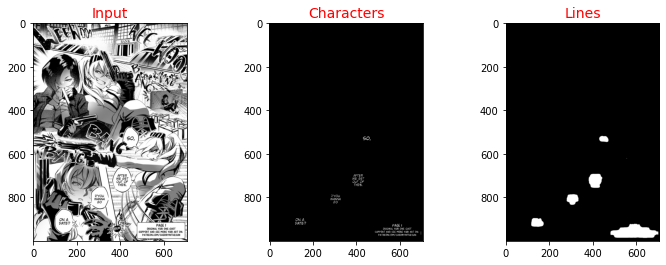

Epoch 19: 100%|██████████| 384/384 [00:42<00:00,  9.01it/s, current_batch_loss=0.0855]


In [12]:
_ = train.train(
    model_name, model,
          train_dataset=training_dataset,
          train_device=device,
          validate_dataset=validation_dataset,
          validate_device=device,
          update_callback=save_and_report,
          update_every_n=20,
          batch_size=10,
          train_epoch_count=20)

# Validation

In [13]:
from comic_ocr.models import localization

In [14]:
default_model = localization.load_model()
model = localization.load_model(model_path)


In [15]:
dataset_example_path = get_path_project_dir('example/manga_annotated')
dataset_example = localization.LocalizationDataset.load_line_annotated_manga_dataset(
    dataset_example_path, batch_image_size=model.preferred_image_size)

localization.calculate_high_level_metrics(model, dataset_example)

{'sample_size': 4,
 'total_line_level_true_positive': 54,
 'total_line_level_false_positive': 37,
 'total_line_level_false_negative': 13,
 'line_level_precision': 0.5934065934065934,
 'line_level_recall': 0.8059701492537313,
 'line_level_accuracy': 0.5192307692307693}

In [16]:
dataset_annotated_path = get_path_project_dir('data/manga_line_annotated')
dataset_annotated = localization.LocalizationDataset.load_line_annotated_manga_dataset(
    dataset_annotated_path, batch_image_size=model.preferred_image_size)

localization.calculate_high_level_metrics(model, dataset_annotated)

{'sample_size': 21,
 'total_line_level_true_positive': 447,
 'total_line_level_false_positive': 201,
 'total_line_level_false_negative': 135,
 'line_level_precision': 0.6898148148148148,
 'line_level_recall': 0.7680412371134021,
 'line_level_accuracy': 0.5708812260536399}

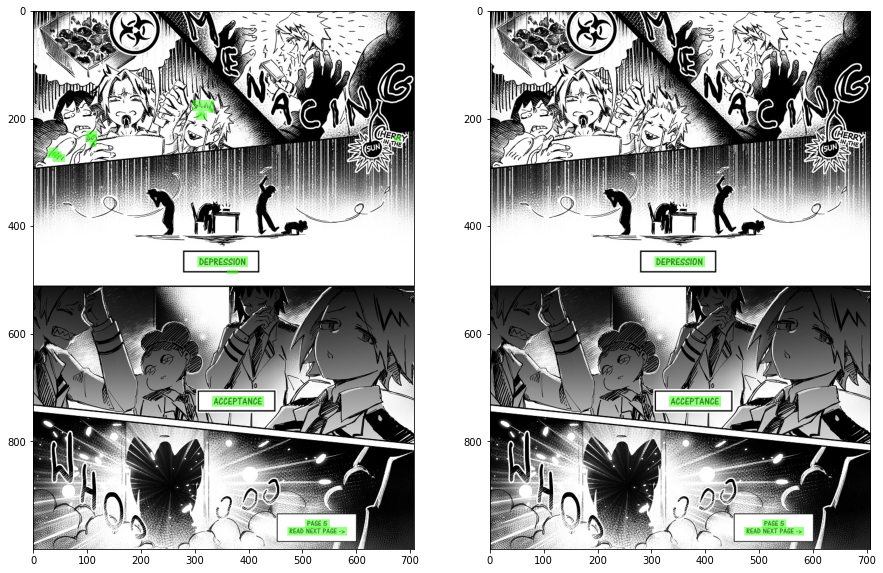

In [17]:
from comic_ocr.utils import image_with_annotations
from comic_ocr.utils.ploting import show_images

def image_with_annotated_lines(model, image):
    paragraph_locations = model.locate_lines(image)
    return image_with_annotations(image, paragraph_locations)


show_images([
    image_with_annotated_lines(model, dataset_example.get_image(0)),
    image_with_annotated_lines(default_model, dataset_example.get_image(0))
])


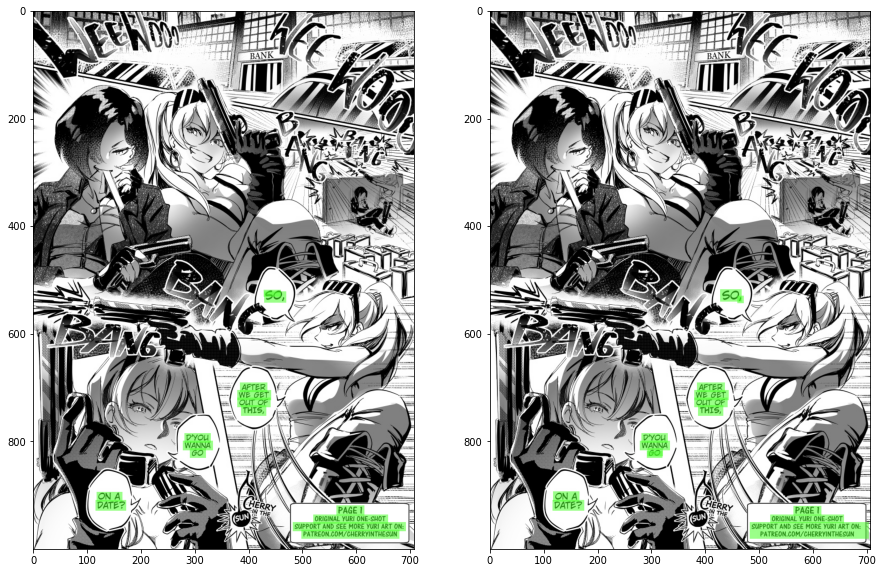

In [18]:
show_images([
    image_with_annotated_lines(model, dataset_example.get_image(1)),
    image_with_annotated_lines(default_model, dataset_example.get_image(1))
])

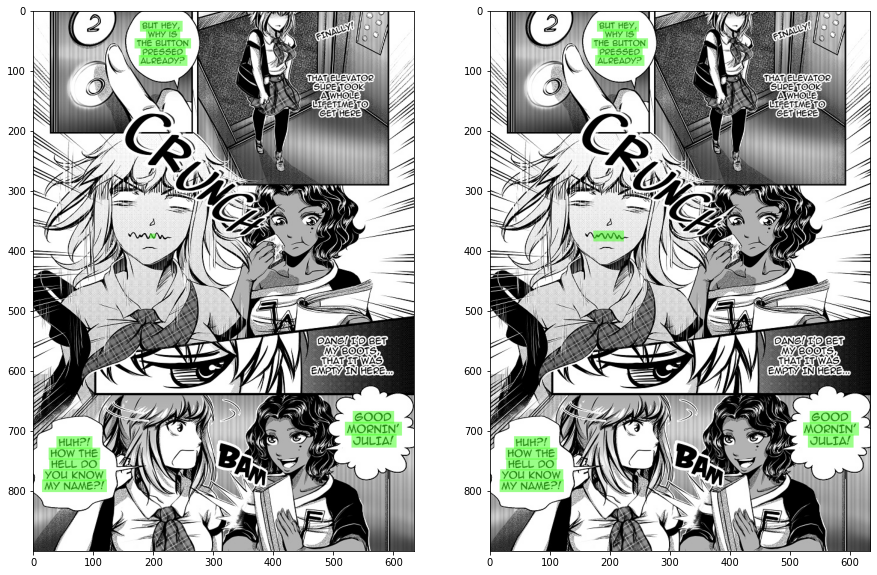

In [19]:
show_images([
    image_with_annotated_lines(model, dataset_example.get_image(2)),
    image_with_annotated_lines(default_model, dataset_example.get_image(2))
])